In [1]:
# Fixes issue with scales::cut_short_scale()
# See: https://github.com/r-lib/scales/issues/413
#devtools::install_github("r-lib/scales", ref = "ee03582")

In [2]:
#install.packages('effsize')

In [3]:
library(tidyverse)
library(scales)
library(RColorBrewer)

library(effsize)
library(ggpubr)
library(ggthemes)
library(ggokabeito)
library(ggvenn)
library(viridis)
library(ComplexUpset)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘ggpubr’


The following objects are masked from ‘package:scales’:

    get_palette, set_palette


Loading required package: grid

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [4]:
options("width" = 100)
options("dplyr.summarise.inform" = FALSE)

In [5]:
print_centered <- function(text) {
  width <- options("width")$width
  padding <- floor((width - nchar(text)) / 2)
  cat(strrep(" ", padding), text, "\n")
}

In [6]:
# Plotting config
icse22_subjects <- c("ant", "closure", "maven", "nashorn", "rhino", "tomcat")
icse22_timeout <- 60
icse22_plot_breaks <- c(0, 20, 40, 60)

split_subjects <- c("ant", "bcel", "chocopy", "closure", "maven", "nashorn", "pngj", "rhino", "tomcat")
split_3h_timeout <- 180
split_3h_plot_breaks <- c(0, 60, 120, 180)
split_5min_timeout <- 5
split_5min_plot_breaks <- c(0, 1, 2, 3, 4, 5)

color_okabe_ito <- c(
    "Zest" = "#E69F00",
    "QuickCheck" = "#56B4E9",
    "RLCheck" = "#009E73",
    "BeDiv-Simple" = "#D55E00",
    "BeDiv-Struct" = "#CC79A7",
    "BeDiv-Havoc" = "#0072B2",
    "BeDiv-Split" = "#000000"
)

color_matplotlib <- c(
    "Zest" = "#FF7F0E",
    "QuickCheck" = "#1F77B4",
    "RLCheck" = "#2CA02C",
    "BeDiv-Simple" = "#D62728",
    "BeDiv-Struct" = "#9467BD",
    "BeDiv-Havoc" = "#8C564B",
    #"BeDiv-Split" = "#E377C2"
    "BeDiv-Split" = "#1F77B4",
    "BeDiv-Simple-V" = "#FF7F0E",
    "BeDiv-Struct-V" = "#1F77B4"
)

plot_shapes <- c(
    "Zest" = "cross",
    "QuickCheck" = "plus",
    "RLCheck" = "asterisk",
    "BeDiv-Simple" = "square open",
    "BeDiv-Struct" = "circle open",
    "BeDiv-Havoc" = "diamond open",
    "BeDiv-Split" = "square cross"
)

## Load coverage data frames 

In [7]:
preprocess_diversity_df <- function(df) {
    return(
        mutate(df, fuzzer = recode(fuzzer,
            "bediv-simple" = "BeDiv-Simple",
            "bedivfuzz-simple" = "BeDiv-Simple",
            "bediv-structure" = "BeDiv-Struct",
            "bedivfuzz-structure" = "BeDiv-Struct",
            "bedivfuzz-havoc" = "BeDiv-Havoc",
            "bedivfuzz-split" = "BeDiv-Split",
            "bedivfuzz-simple-valid" = "BeDiv-Simple-V",
            "bedivfuzz-structure-valid" = "BeDiv-Struct-V",
            "quickcheck" = "QuickCheck",
            "rl" = "RLCheck",
            "rlcheck" = "RLCheck",
            "zest" = "Zest"
        )) |>
        mutate(unique_valid_paths_rate = unique_valid_paths / total_inputs) |>
        pivot_longer(
            cols = c(unique_valid_paths_rate, unique_valid_paths, b0, b1, b2),
            names_to = "measure",
            values_to = "score"
        )
    )
}

In [8]:
coverage_baseline <- read.csv("results/eval-bedivfuzz-baseline/coverage-data.csv") |>
  mutate(
    total_inputs = valid_inputs + invalid_inputs,
    time = time / 60 # Convert seconds to minutes
  ) |>
  select(fuzzer, subject, trial, time, total_inputs, unique_valid_paths, b0, b1, b2) |>
  preprocess_diversity_df()

coverage_icse22 <- read.csv("results/eval-icse22/coverage/coverage-data.csv") |>
  select(fuzzer, subject, trial, time, total_inputs, unique_valid_paths, b0, b1, b2) |>
  preprocess_diversity_df()

coverage_split_3h_default <- read.csv("results/eval-bedivfuzz-split-3h/default/coverage-data.csv") |>
  filter(fuzzer != "quickcheck") |>
  mutate(
    total_inputs = valid_inputs + invalid_inputs,
    time = time / 60 # Convert seconds to minutes
  ) |>
  select(fuzzer, subject, trial, time, total_inputs, unique_valid_paths, b0, b1, b2) |>
  preprocess_diversity_df()

coverage_split_5min_default <- read.csv("results/eval-bedivfuzz-split-5min/default/coverage-data.csv") |>
  filter(fuzzer != "quickcheck") |>
  mutate(
    total_inputs = valid_inputs + invalid_inputs,
    time = time / 60
  ) |>
  select(fuzzer, subject, trial, time, total_inputs, unique_valid_paths, b0, b1, b2) |>
  preprocess_diversity_df()

coverage_split_3h_semantic <- read.csv("results/eval-bedivfuzz-split-3h/semantic/coverage-data.csv") |>
  filter(fuzzer != "quickcheck") |>
  mutate(
    total_inputs = valid_inputs + invalid_inputs,
    time = time / 60
  ) |>
  select(fuzzer, subject, trial, time, total_inputs, unique_valid_paths, b0, b1, b2) |>
  preprocess_diversity_df()

coverage_split_5min_semantic <- read.csv("results/eval-bedivfuzz-split-5min/semantic/coverage-data.csv") |>
  filter(fuzzer != "quickcheck") |>
  mutate(
    total_inputs = valid_inputs + invalid_inputs,
    time = time / 60
  ) |>
  select(fuzzer, subject, trial, time, total_inputs, unique_valid_paths, b0, b1, b2) |>
  preprocess_diversity_df()

In [9]:
extract_legend <- function(df, color_palette) {
  # Create a dummy plot
  p <- ggplot(subset(df, time == min(time)), aes(time, time, color = fuzzer, fill = fuzzer, shape = fuzzer))  +
    geom_line() +
    geom_point(size = 3) +
    geom_ribbon(aes(ymin = time - 1, ymax = time + 1), alpha = 0.4, linetype = 0) +
    scale_color_manual(values = color_palette) +
    scale_fill_manual(values = color_palette) +
    scale_shape_manual(values = plot_shapes) +
    labs(color = "Fuzzer", fill = "Fuzzer", linetype = "Fuzzer", shape = "Fuzzer") +
    guides(color = guide_legend(ncol = 5)) + # Wrap into 3 columns
    theme(legend.key.width = unit(1, "cm"))
  # Extract the legend. Returns a gtable
  leg <- get_legend(p)

  # Convert to a ggplot and print
  return(as_ggplot(leg))
}

Saving 7 x 7 in image


[1] "plots/legend/legend-icse22.pdf"

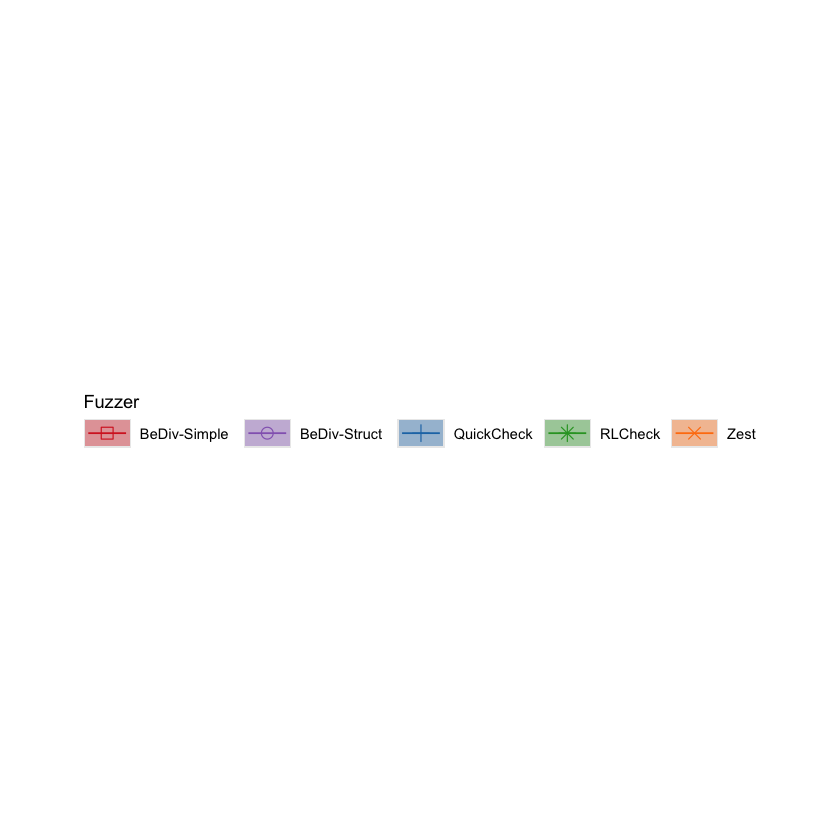

In [10]:
extract_legend(coverage_icse22, color_palette = color_matplotlib)
ggsave("plots/legend/legend-icse22.pdf", create.dir = TRUE)
knitr::plot_crop("plots/legend/legend-icse22.pdf")

Saving 7 x 7 in image


[1] "plots/legend/legend-split.pdf"

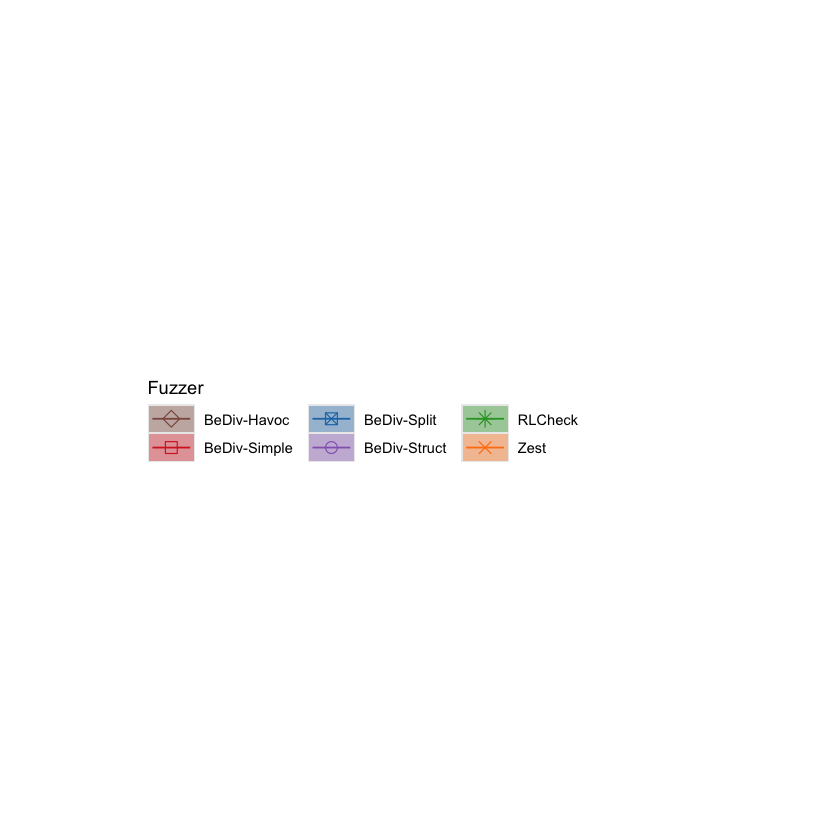

In [11]:
extract_legend(coverage_split_3h_default, color_palette = color_matplotlib)
ggsave("plots/legend/legend-split.pdf", create.dir = TRUE)
knitr::plot_crop("plots/legend/legend-split.pdf")

In [12]:
plot_diverse_valids <- function(
  df,
  benchmark_program,
  color_palette,
  time_breaks,
  transform_y = "identity",
  experiment_name = "",
  save_file = FALSE,
  remove_legend = FALSE
) {
  df <- subset(df, subject == benchmark_program & measure == "unique_valid_paths") |>
    group_by(fuzzer, subject, time, measure) |>
    summarize(
      mean_score = mean(score, na.rm = TRUE),
      std_error = sd(score, na.rm = TRUE) / sqrt(n())
    )

  plt <- ggplot(df, aes(time, mean_score, color = fuzzer, fill = fuzzer, shape = fuzzer)) +
    geom_line(linewidth = 0.5) +
    geom_point(data = subset(df, time %in% time_breaks), size = 2) +
    geom_ribbon(aes(ymin = mean_score - std_error, ymax = mean_score + std_error), alpha = 0.35, linetype = 0) +
    scale_x_continuous(name = "Time (min)", breaks = time_breaks) +
    scale_y_continuous(
      name = "Diverse Valid Inputs",
      labels = scales::label_number(scale_cut = scales::cut_short_scale()),
      transform = transform_y
    ) +
    scale_color_manual(values = color_palette) +
    scale_fill_manual(values = color_palette) +
    scale_shape_manual(values = plot_shapes) +
    labs(color = "Fuzzer", fill = "Fuzzer", shape = "Fuzzer") +
    theme(aspect.ratio = 0.5)

  if (remove_legend) {
    plt <- plt + theme(legend.position = "none")
  }

  if (save_file) {
    plot_name <- sprintf(
      "plots/%sdiversity/diverse_valids/%s%s.pdf",
      ifelse(experiment_name == "", "", paste(experiment_name, "/", sep = "")),
      ifelse(transform_y == "identity", "", paste(transform_y, "/", sep = "")),
      subject
    )
    ggsave(plot_name, scale = 0.5, create.dir = TRUE)
    knitr::plot_crop(plot_name)
  }

  return(plt)
}

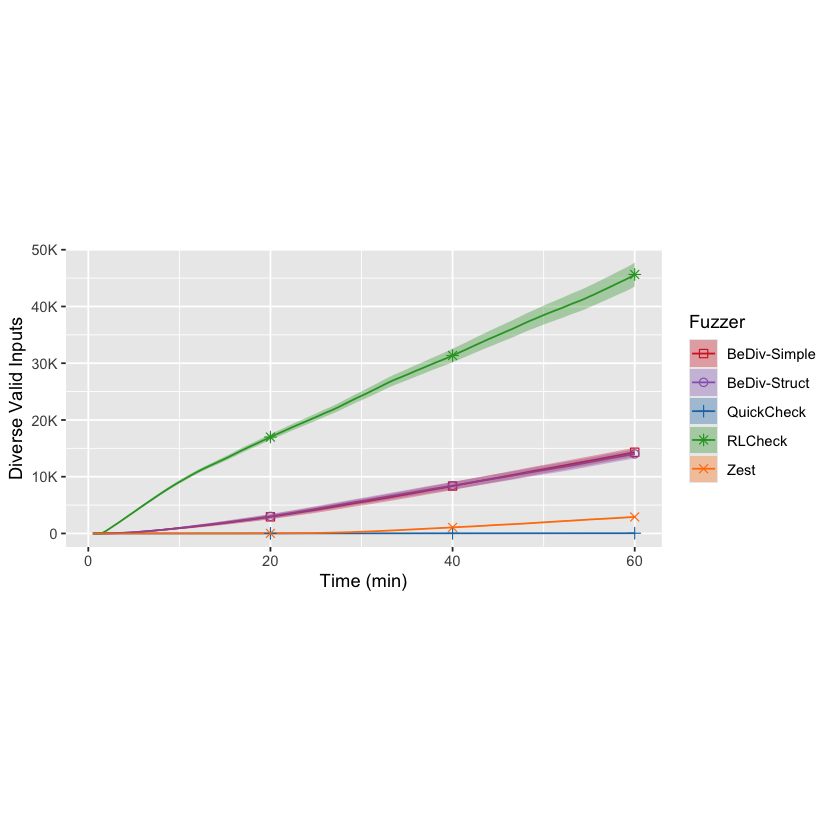

In [13]:
plot_diverse_valids(
  df = coverage_icse22,
  benchmark_program = "ant",
  color_palette = color_matplotlib,
  time_breaks = icse22_plot_breaks,
  transform_y = "identity"
)

In [14]:
plot_diverse_valids_percent <- function(
  df,
  benchmark_program,
  color_palette,
  time_breaks,
  experiment_name = "", save_file = FALSE, remove_legend = FALSE
) {
  df <- subset(df, subject == benchmark_program & measure == "unique_valid_paths_rate") |>
    group_by(fuzzer, subject, time, measure) |>
    summarize(
      mean_score = mean(score, na.rm = TRUE),
      std_error = sd(score, na.rm = TRUE) / sqrt(n())
    )

  plt <- ggplot(df, aes(time, mean_score, color = fuzzer, fill = fuzzer, shape = fuzzer)) +
    geom_line() +
    geom_point(data = subset(df, time %in% time_breaks), size = 2) +
    geom_ribbon(aes(ymin = mean_score - std_error, ymax = mean_score + std_error), alpha = 0.4, linetype = 0) +
    scale_x_continuous(name = "Time (min)", breaks = time_breaks) +
    scale_y_continuous(
      name = "Diverse Valid Inputs (%)",
      labels = scales::label_percent(suffix = "")
    ) +
    scale_color_manual(values = color_palette) +
    scale_fill_manual(values = color_palette) +
    scale_shape_manual(values = plot_shapes) +
    labs(color = "Fuzzer", fill = "Fuzzer", shape = "Fuzzer") +
    theme(aspect.ratio = 0.5)

  if (remove_legend) {
    plt <- plt + theme(legend.position = "none")
  }

  if (save_file) {
    plot_name <- sprintf(
      "plots/%sdiversity/unique_valid_paths_rate/%s.pdf",
      ifelse(experiment_name == "", "", paste(experiment_name, "/", sep = "")),
      subject
    )
    ggsave(plot_name, scale = 0.5, create.dir = TRUE)
    knitr::plot_crop(plot_name)
  }

  return(plt)
}

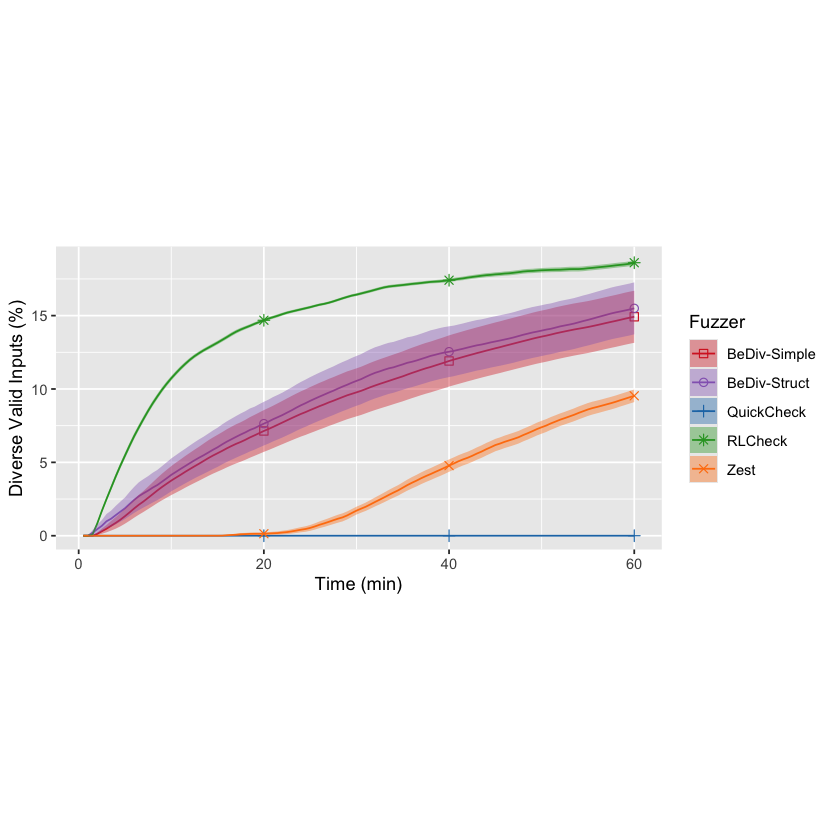

In [15]:
plot_diverse_valids_percent(
  df = coverage_icse22,
  benchmark_program = "ant",
  color_palette = color_matplotlib,
  time_breaks = icse22_plot_breaks
)

In [14]:
suppressWarnings({
  for (subject in icse22_subjects) {
    for (transformation in c("identity", "log2", "log10")) {
      plot_diverse_valids(
        coverage_icse22, subject, color_matplotlib, icse22_plot_breaks, transformation,
        experiment_name = "eval-icse22", save_file = TRUE, remove_legend = TRUE
      )
    }
    plot_diverse_valids_percent(
      coverage_icse22, subject, color_matplotlib, icse22_plot_breaks,
      experiment_name = "eval-icse22", save_file = TRUE, remove_legend = TRUE
    )
  }


  for (subject in split_subjects) {
    for (transformation in c("identity", "log2", "log10")) {
      plot_diverse_valids(
        coverage_split_3h_default, subject, color_matplotlib, split_3h_plot_breaks, transformation,
        experiment_name = "eval-bedivfuzz-split-3h-default", save_file = TRUE, remove_legend = TRUE
      )

      plot_diverse_valids(
        coverage_split_5min_default, subject, color_matplotlib, split_5min_plot_breaks, transformation,
        experiment_name = "eval-bedivfuzz-split-5min-default", save_file = TRUE, remove_legend = TRUE
      )
    }

    plot_diverse_valids_percent(
      coverage_split_3h_default, subject, color_matplotlib, split_3h_plot_breaks, 
      experiment_name = "eval-bedivfuzz-split-3h-default", save_file = TRUE, remove_legend = TRUE
    )

    plot_diverse_valids_percent(
      coverage_split_5min_default, subject, color_matplotlib, split_5min_plot_breaks,
      experiment_name = "eval-bedivfuzz-split-5min-default", save_file = TRUE, remove_legend = TRUE
    )
  }
})

Saving 3.5 x 3.5 in image


Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x 3.5 in image
Saving 3.5 x

In [16]:
plot_behavioral_diversity_grid <- function(
  df,
  color_palette,
  time_breaks,
  transform_y = "identity",
  experiment_name = "",
  save_file = FALSE
) {
  df <- subset(df, measure %in% c("b0", "b1", "b2")) |>
    group_by(fuzzer, subject, time, measure) |>
    summarize(
      mean_score = mean(score, na.rm = TRUE),
      std_error = sd(score, na.rm = TRUE) / sqrt(n())
    ) |>
    mutate(measure = recode(measure, "b0" = "B(0)", "b1" = "B(1)", "b2" = "B(2)")) |> 
    ungroup()

  plt <- ggplot(df, aes(time, mean_score, color = fuzzer, fill = fuzzer, shape = fuzzer)) +
    geom_line() +
    geom_point(data = subset(df, time %in% time_breaks), size = 1.5) +
    geom_ribbon(aes(ymin = mean_score - std_error, ymax = mean_score + std_error), alpha = 0.3, linetype = 0) +
    scale_x_continuous(name = "Time (min)", breaks = c(0, 20, 40, 60)) +
    scale_y_continuous(
      name = "Behavioral Diversity",
      labels = scales::label_number(scale_cut = scales::cut_short_scale()),
      transform = transform_y
    ) +
    scale_color_manual(values = color_palette) +
    scale_fill_manual(values = color_palette) +
    scale_shape_manual(values = plot_shapes) +
    labs(color = "Fuzzer", fill = "Fuzzer", shape = "Fuzzer") +
    facet_grid(subject ~ measure, scales = "free") +
    theme(aspect.ratio = 1.0, legend.position = "bottom")

  if (save_file) {
    plot_name <- sprintf(
      "plots/%sdiversity/behavioral_diversity/diversity_over_time.pdf",
      ifelse(experiment_name == "", "", paste(experiment_name, "/", sep = ""))
    )

    ggsave(plot_name, scale = 1.2, create.dir = TRUE)
    knitr::plot_crop(plot_name)
  }

  return(plt)
}


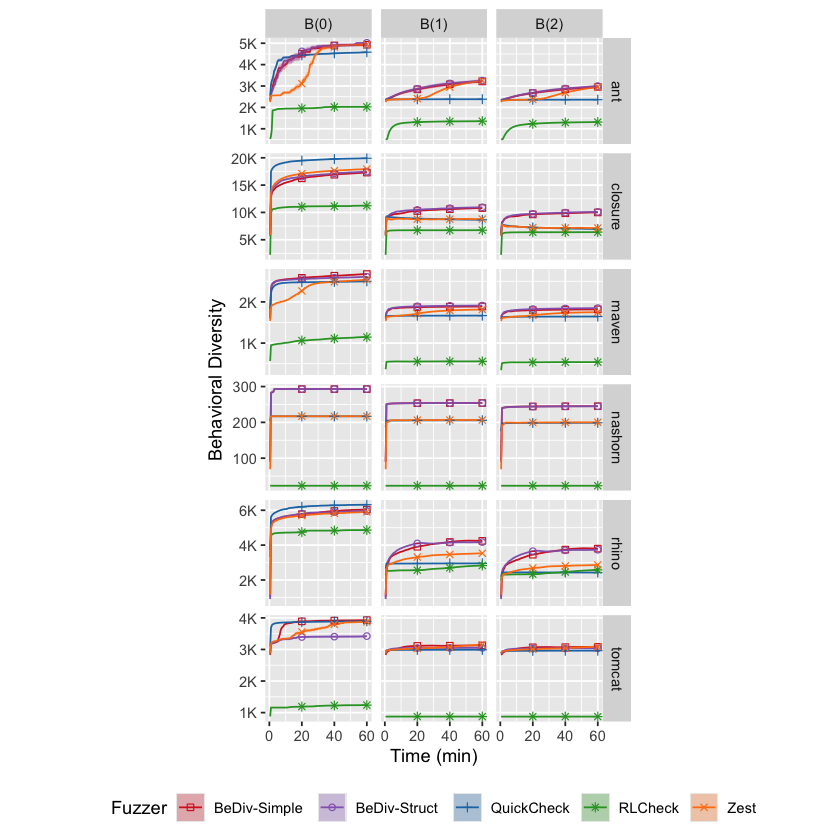

In [17]:
plot_behavioral_diversity_grid(
  coverage_icse22,
  color_palette = color_matplotlib,
  time_breaks = icse22_plot_breaks,
  transform_y = "identity"
)

In [18]:
plot_bediv_boxplot <- function(df, color_palette, experiment_name = "", save_file = FALSE) {
  df <- subset(df, measure %in% c("b0", "b1", "b2") & time == max(time)) |>
    mutate(measure = recode(measure, "b0" = "B(0)", "b1" = "B(1)", "b2" = "B(2)"))

  plt <- ggplot(df, aes(fuzzer, score, color = fuzzer)) +
    geom_boxplot() +
    scale_y_continuous(
      name = "Behavioral Diversity",
      labels = scales::label_number(scale_cut = scales::cut_short_scale())
    ) +
    scale_color_manual(values = color_palette) +
    xlab("Fuzzer") +
    labs(color = "Fuzzer", fill = "Fuzzer", linetype = "Fuzzer") +
    facet_grid(subject ~ measure, scales = "free_y") +
    theme(
      aspect.ratio = 1.0,
      #axis.text.x = element_text(angle = 45, hjust = 1),
      axis.ticks.x = element_blank(),   # Remove x-axis ticks
      axis.text.x = element_blank(),  # Remove x-axis labels
      legend.position = "bottom"
    )

  if (save_file) {
    plot_name <- sprintf(
      "plots/%sdiversity/behavioral_diversity/final_diversity_boxplot.pdf",
      ifelse(experiment_name == "", "", paste(experiment_name, "/", sep = ""))
    )
    ggsave(plot_name, scale = 1.2, create.dir = TRUE)
    knitr::plot_crop(plot_name)
  }

  return(plt)
}

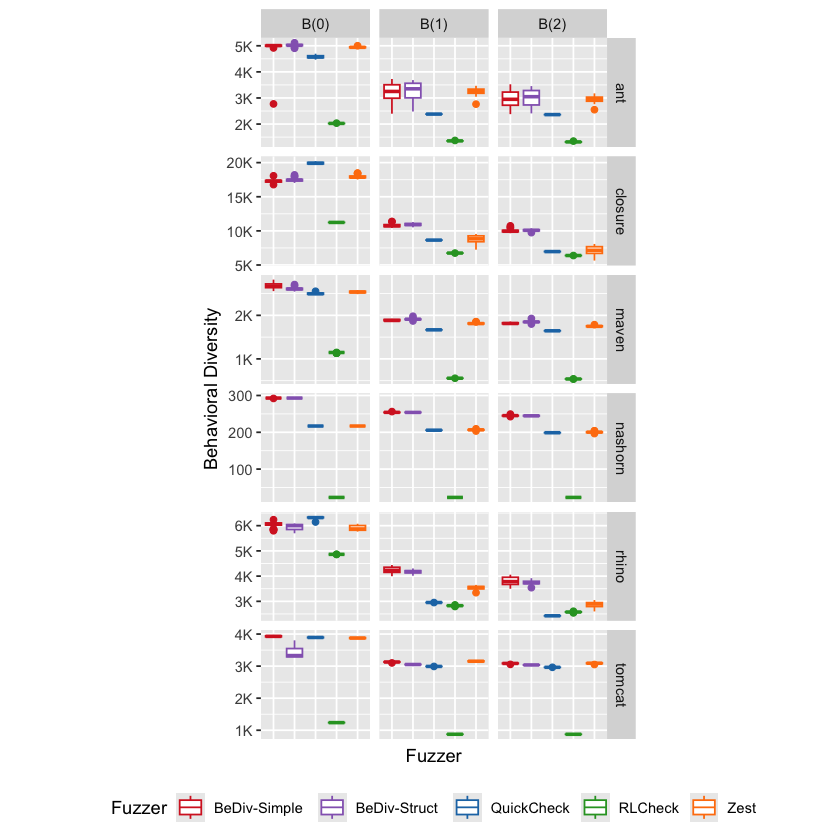

In [19]:
plot_bediv_boxplot(coverage_icse22, color_palette = color_matplotlib)

Saving 8.4 x 8.4 in image
Saving 8.4 x 8.4 in image
Saving 8.4 x 8.4 in image
Saving 8.4 x 8.4 in image


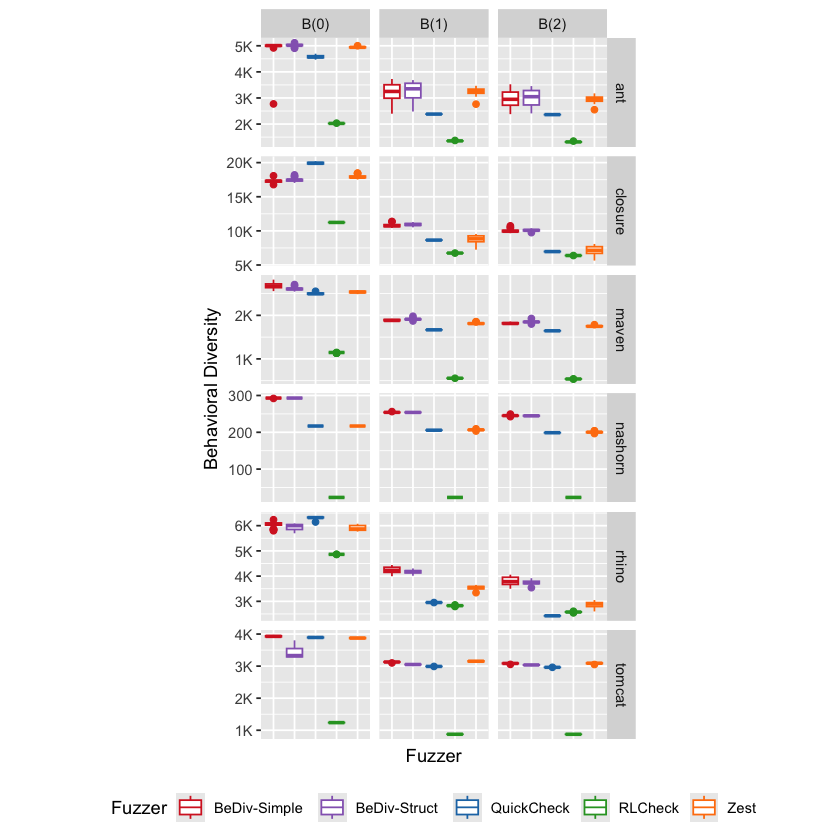

In [20]:
for (transformation in c("identity", "log2", "log10")) {
  plot_behavioral_diversity_grid(
    coverage_icse22,
    color_palette = color_matplotlib,
    time_breaks = icse22_plot_breaks,
    transform_y = transformation,
    experiment_name = "eval-icse22",
    save_file = TRUE
  )
}

plot_bediv_boxplot(coverage_icse22, color_palette = color_matplotlib, experiment_name = "eval-icse22", save_file = TRUE)

In [21]:
plot_performance <- function(
  df,
  metric,
  color_palette,
  time_breaks,
  transform_y = "identity",
  experiment_name = "",
  save_file = FALSE
) {
  df <- subset(df, measure == metric[1] & time > 1) |>
    group_by(fuzzer, subject, time) |>
    summarize(
      mean_score = mean(score, na.rm = TRUE),
      std_error = sd(score, na.rm = TRUE) / sqrt(n())
    ) |>
    ungroup()

  plt <- ggplot(df, aes(time, mean_score, color = fuzzer, fill = fuzzer, shape = fuzzer)) +
    geom_line() +
    geom_point(data = subset(df, time %in% time_breaks), size = 1.5) +
    geom_ribbon(aes(ymin = mean_score - std_error, ymax = mean_score + std_error), alpha = 0.3, linetype = 0) +
    scale_x_continuous(name = "Time (min)", breaks = time_breaks) +
    scale_y_continuous(
      name = paste("Mean", metric[2], sep = " "),
      labels = ifelse(
        metric[1] == "unique_valid_paths_rate",
        scales::label_percent(suffix = ""),
        scales::label_number(scale_cut = scales::cut_short_scale())
      ),
      transform = transform_y
    ) +
    scale_color_manual(values = color_palette) +
    scale_fill_manual(values = color_palette) +
    scale_shape_manual(values = plot_shapes) +
    labs(color = "Fuzzer", fill = "Fuzzer", shape = "Fuzzer") +
    facet_wrap(~ subject, ncol = 3, scales = "free_y") +
    theme(
      aspect.ratio = 1,
      #legend.position = "bottom"
    )

  if (save_file) {
    plot_name <- sprintf(
      "plots/%sdiversity/%s/%sperformance_over_time.pdf",
      ifelse(experiment_name == "", "", paste(experiment_name, "/", sep = "")),
      metric[1],
      ifelse(transform_y == "identity", "", paste(transform_y, "/", sep = ""))
    )

    ggsave(plot_name, create.dir = TRUE)
    knitr::plot_crop(plot_name)
  }

  return(plt)
}

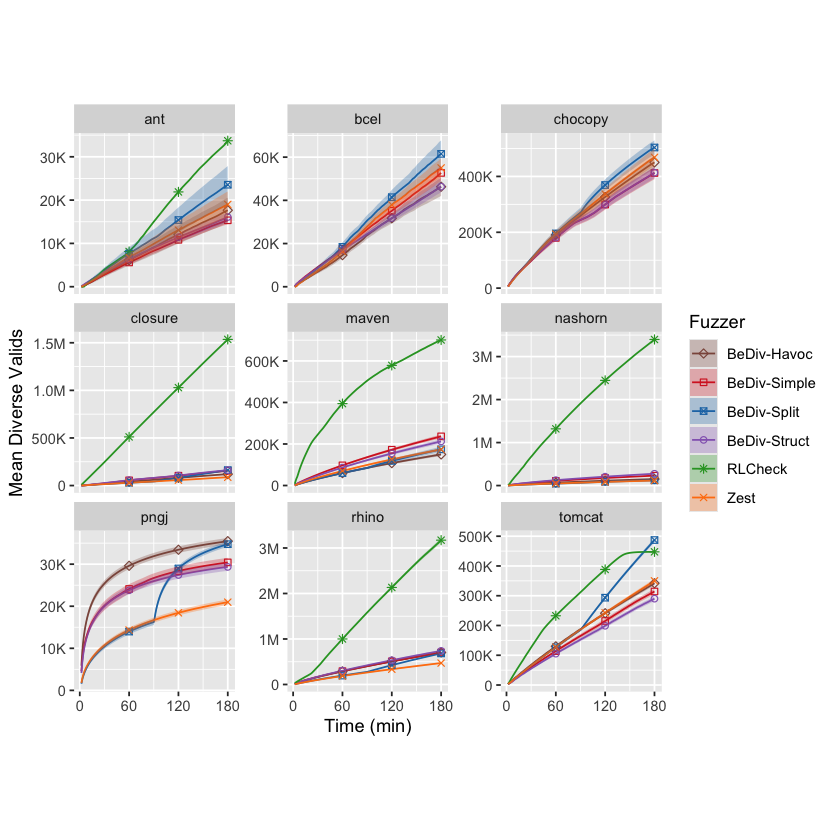

In [22]:
plot_performance(
  coverage_split_3h_default,
  metric = c("unique_valid_paths", "Diverse Valids"),
  color_palette = color_matplotlib,
  time_breaks = split_3h_plot_breaks,
  transform_y = "identity"
)

In [203]:
subset(bediv_superiority, value < 0)

time,variable,value
<dbl>,<chr>,<dbl>
1,mean_simple,-9
1,mean_struct,-9
2,mean_simple,-3
2,mean_struct,-4
3,mean_simple,-2
3,mean_struct,-2
4,mean_simple,-2
12,mean_simple,-1


Saving 4.9 x 4.9 in image


[1] "plots/eval-bedivfuzz-baseline/ps_vs_v_superiority_b0.pdf"

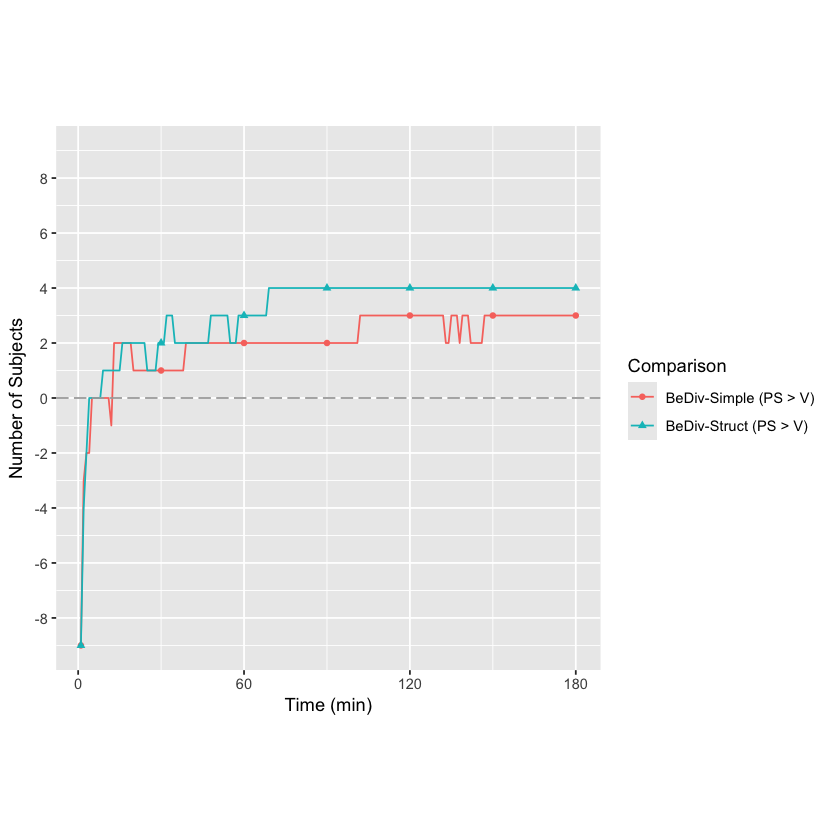

In [201]:
metric <- "b0"

df <- coverage_baseline |>
  subset(measure == metric)

time_points <- unique(df$time)
subjects <- unique(df$subject)
results <- list()

for (s in subjects) {
  for (t in time_points) {
    subset_df <- subset(df, subject == s & time == t)

    simple_scores <- subset_df$score[subset_df$fuzzer == "BeDiv-Simple"]
    simple_v_scores <- subset_df$score[subset_df$fuzzer == "BeDiv-Simple-V"]
    simple_pvalue <- wilcox.test(simple_scores, simple_v_scores, paired = FALSE, exact = FALSE)$p.value

    struct_scores <- subset_df$score[subset_df$fuzzer == "BeDiv-Struct"]
    struct_v_scores <- subset_df$score[subset_df$fuzzer == "BeDiv-Struct-V"]
    struct_pvalue <- wilcox.test(struct_scores, struct_v_scores, paired = FALSE, exact = FALSE)$p.value

    results <- rbind(results, data.frame(
      subject = s,
      time = t,
      p_simple = simple_pvalue,
      p_struct = struct_pvalue,
      mean_simple = sign(mean(simple_scores) - mean(simple_v_scores)),
      mean_struct = sign(mean(struct_scores) - mean(struct_v_scores)),
      median_simple = sign(median(simple_scores) - median(simple_v_scores)),
      median_struct = sign(median(struct_scores) - median(struct_v_scores))
    ))
  }
}

alpha <- 0.01
bediv_superiority <- as.data.frame(results) |>
  mutate(
    mean_simple = ifelse(p_simple <= alpha, mean_simple, 0),
    median_simple = ifelse(p_simple <= alpha, median_simple, 0),
    mean_struct = ifelse(p_struct <= alpha, mean_struct, 0),
    median_struct = ifelse(p_struct <= alpha, median_struct, 0),
  ) |>
  group_by(time) |>
  summarize(
    mean_simple = sum(mean_simple),
    median_simple = sum(median_simple),
    mean_struct = sum(mean_struct),
    median_struct = sum(median_struct)

  ) |>
  pivot_longer(cols = -time, names_to = "variable", values_to = "value") |>
  subset(variable %in% c("mean_simple", "mean_struct"))

s <- bediv_superiority |> mutate(
  Comparison = recode(variable,
    "mean_simple" = "BeDiv-Simple (PS > V)",
    "median_simple" = "BeDiv-Simple (median)",
    "mean_struct" = "BeDiv-Struct (PS > V)",
    "median_struct" = "BeDiv-Struct (median)"
)
)

ggplot(s, aes(time, value, color = Comparison, shape = Comparison)) +
  geom_line()  +
  geom_hline(
    yintercept = 0,
    linetype = "longdash",
    color = "darkgrey",
    linewidth = 0.5
  ) +
  geom_point(data = subset(s, time %in% c(1, 30, 60, 90, 120, 150, 180)), size = 1.5)  +
  scale_x_continuous(name = "Time (min)", breaks = split_3h_plot_breaks) +
  scale_y_continuous(
    breaks = c(-8, -6, -4, -2, 0, 2, 4, 6, 8),
    limits = c(-9, 9),
    name = "Number of Subjects"
  ) +
  theme(
    aspect.ratio = 1,
  )

plot_name <- sprintf("plots/eval-bedivfuzz-baseline/ps_vs_v_superiority_%s.pdf", metric)
ggsave(plot_name, create.dir = TRUE, scale = 0.7)
knitr::plot_crop(plot_name)

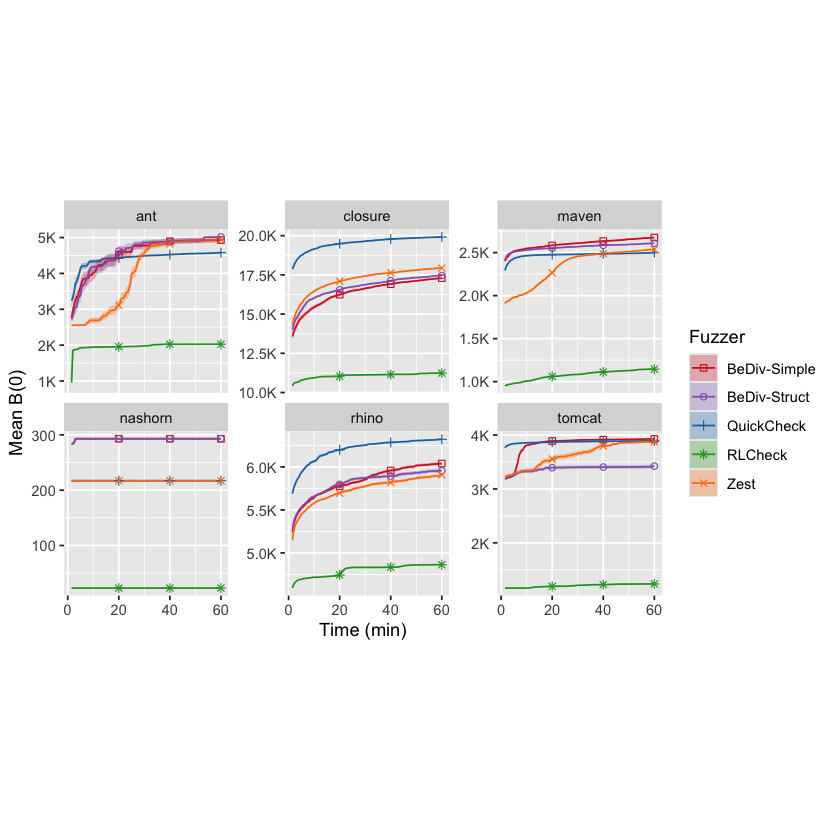

In [24]:
plot_performance(
  coverage_icse22,
  metric = c("b0", "B(0)"),
  color_palette = color_matplotlib,
  time_breaks = icse22_plot_breaks,
  transform_y = "identity"
)

In [25]:
plot_performance_boxplot <- function(df, metric, color_palette, experiment_name = "", save_file = FALSE) {
  plt <- ggplot(
    subset(df, measure == metric[1] & time == max(time)),
    aes(fuzzer, score, color = fuzzer)
  ) +
    geom_boxplot() +
    scale_y_continuous(
      name = paste("Final", metric[2], sep = " "),
      labels = ifelse(
        metric[1] == "unique_valid_paths_rate",
        scales::label_percent(suffix = ""),
        scales::label_number(scale_cut = scales::cut_short_scale())
      )
    ) +
    scale_color_manual(values = color_palette) +
    xlab("Fuzzer") +
    labs(color = "Fuzzer", fill = "Fuzzer", linetype = "Fuzzer") +
    facet_wrap(~ subject, ncol = 3, scales = "free_y") +
    theme(
      aspect.ratio = 1.0,
      #axis.text.x = element_text(angle = 45, hjust = 1),
      axis.ticks.x = element_blank(),   # Remove x-axis ticks
      axis.text.x = element_blank(),  # Remove x-axis labels
    )

  if (save_file) {
    plot_name <- sprintf(
      "plots/%sdiversity/%s/final_performance_boxplot.pdf",
      ifelse(experiment_name == "", "", paste(experiment_name, "/", sep = "")),
      metric[1]
    )

    ggsave(plot_name, create.dir = TRUE)
    knitr::plot_crop(plot_name)
  }

  return(plt)
}

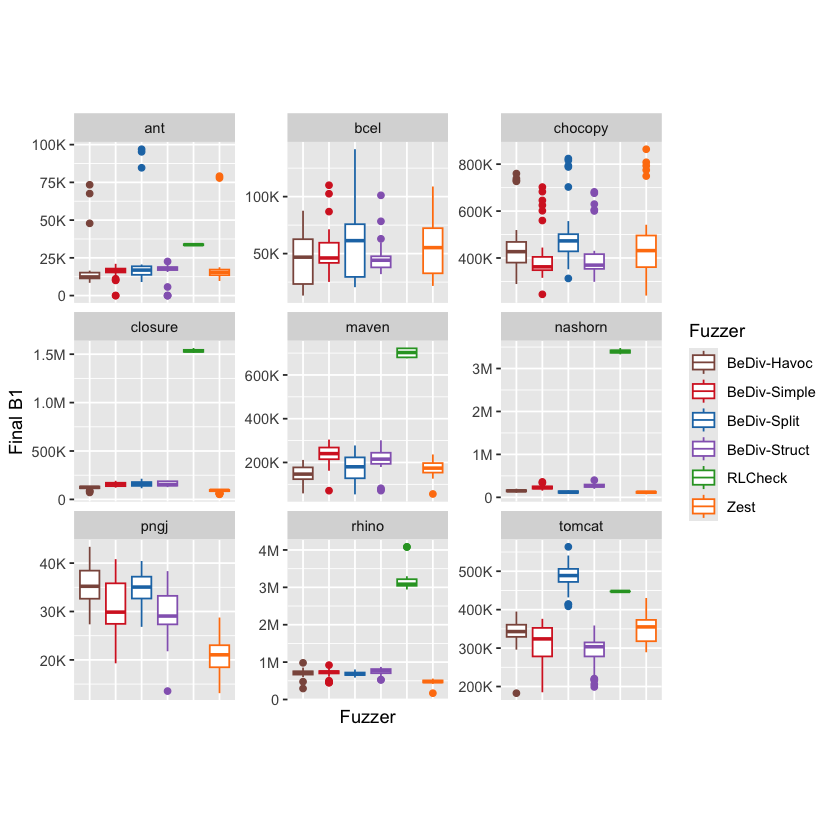

In [26]:
plot_performance_boxplot(
  coverage_split_3h_default,
  metric = c("unique_valid_paths", "B1"),
  color_palette = color_matplotlib
)

In [27]:
ml <- list(
  c("unique_valid_paths", "Diverse Valid Inputs"),
  c("unique_valid_paths_rate", "Diverse Valid Inputs (%)"),
  c("b0", "B(0)"),
  c("b1", "B(1)"),
  c("b2", "B(2)")
)

suppressWarnings({
  for (metric_label in ml) {
    for (transformation in c("identity", "log2", "log10")) {
      plot_performance(
        coverage_split_3h_default, metric_label, color_matplotlib, split_3h_plot_breaks, transformation,
        experiment_name = "eval-bedivfuzz-split-3h-default", save_file = TRUE
      )

      plot_performance(
        coverage_split_3h_semantic, metric_label, color_matplotlib, split_3h_plot_breaks, transformation,
        experiment_name = "eval-bedivfuzz-split-3h-semantic", save_file = TRUE
      )

      plot_performance(
        coverage_split_5min_default, metric_label, color_matplotlib, split_5min_plot_breaks, transformation,
        experiment_name = "eval-bedivfuzz-split-5min-default", save_file = TRUE
      )

      plot_performance(
        coverage_split_5min_semantic, metric_label, color_matplotlib, split_5min_plot_breaks, transformation,
        experiment_name = "eval-bedivfuzz-split-5min-semantic", save_file = TRUE
      )
    }

    plot_performance_boxplot(
      coverage_split_3h_default, metric_label, color_matplotlib,
      experiment_name = "eval-bedivfuzz-split-3h-default", save_file = TRUE
    )

    plot_performance_boxplot(
      coverage_split_3h_semantic, metric_label, color_matplotlib,
      experiment_name = "eval-bedivfuzz-split-3h-semantic", save_file = TRUE
    )

    plot_performance_boxplot(
      coverage_split_5min_default, metric_label, color_matplotlib,
      experiment_name = "eval-bedivfuzz-split-5min-default", save_file = TRUE
    )

    plot_performance_boxplot(
      coverage_split_5min_semantic, metric_label, color_matplotlib,
      experiment_name = "eval-bedivfuzz-split-5min-semantic", save_file = TRUE
    )
  }
})

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x

In [96]:
evaluate_final_performance <- function(df, metric, benchmark_program, timeout) {
  print_centered(paste("[ Evaluating final", metric, "performance for", benchmark_program, "]\n", sep = " "))
  scores <- subset(df, measure == metric & subject == benchmark_program & time == timeout)

  avg_scores <- subset(scores, measure == metric & subject == benchmark_program & time == max(time)) |>
    group_by(fuzzer) |>
    summarize(mean_score = mean(score), median_score = median(score)) |>
    mutate(mean_rank = rank(-mean_score), median_rank = rank(-median_score)) |>
    select(fuzzer, mean_score, mean_rank, median_score, median_rank)

  print_centered("Average performance scores")
  print(avg_scores)

  p_values <- pairwise.wilcox.test(scores$score, scores$fuzzer, p.adjust.method = "none", exact = FALSE, paired = FALSE)
  print(p_values)

  cat("\n")
  print_centered("Pairwise comparison of effect size (Vargha-Delaney A12)\n")
  # Unique combinations of method pairs
  fuzzer_combinations <- combn(unique(scores$fuzzer), 2)

  # Perform pairwise Vargha-Delaney A-Test
  vd_results <- apply(fuzzer_combinations, 2, function(pair) {
    group1 <- scores$score[scores$fuzzer == pair[1]]
    group2 <- scores$score[scores$fuzzer == pair[2]]
    result <- VD.A(group1, group2)
    data.frame(
      Group1 = pair[1],
      Group2 = pair[2],
      A = result$estimate,
      Interpretation = result$magnitude
    )
  })

  # Combine results into a single data frame
  vd_results <- do.call(rbind, vd_results)
  print(vd_results)

}

In [107]:
evaluate_final_performance(coverage_icse22, "b0", "ant", timeout = 5)

                             [ Evaluating final b0 performance for ant ]
 
                                      Average performance scores 
# A tibble: 5 × 5
  fuzzer       mean_score mean_rank median_score median_rank
  <chr>             <dbl>     <dbl>        <dbl>       <dbl>
1 BeDiv-Simple      3607.         2        2758.           2
2 BeDiv-Struct      3373.         3        2713            3
3 QuickCheck        4143          1        4335            1
4 RLCheck           1927.         5        1928            5
5 Zest              2562.         4        2562.           4

	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  scores$score and scores$fuzzer 

             BeDiv-Simple BeDiv-Struct QuickCheck RLCheck
BeDiv-Struct 0.745        -            -          -      
QuickCheck   0.093        0.011        -          -      
RLCheck      2.5e-11      2.5e-11      2.5e-11    -      
Zest         1.5e-10      3.9e-11      2.9e-11    2.4e-11

P 

## Crash analysis

In [109]:
fuzzer_crashes <- read.csv("results/eval-icse22/crashes/crash-data.csv") |>
  filter(fuzzer != "quickcheck") |> # Remove quickcheck results for bedivfuzz-split eval
  filter(crash_id != "-1" & tte != -1) |> # Filter out false positives
  mutate(tte = tte / 1000) # Convert ms to s

In [110]:
# Total number of crashes found
cat("Total number of crashes found:")
fuzzer_crashes |>
  distinct(fuzzer, subject, crash_id) |>
  group_by(fuzzer) |>
  summarize(
    crash_count = n()
  )

Total number of crashes found:

fuzzer,crash_count
<chr>,<int>
bediv-simple,13
bediv-structure,13
rl,15
zest,13


UpSet plot of total crash coverage:

✔ Created directory: plots/eval-bedivfuzz-split-3h/crashes.

Saving 7 x 7 in image


[1] "plots/eval-bedivfuzz-split-3h/crashes/crash_coverage_upset_plot.pdf"

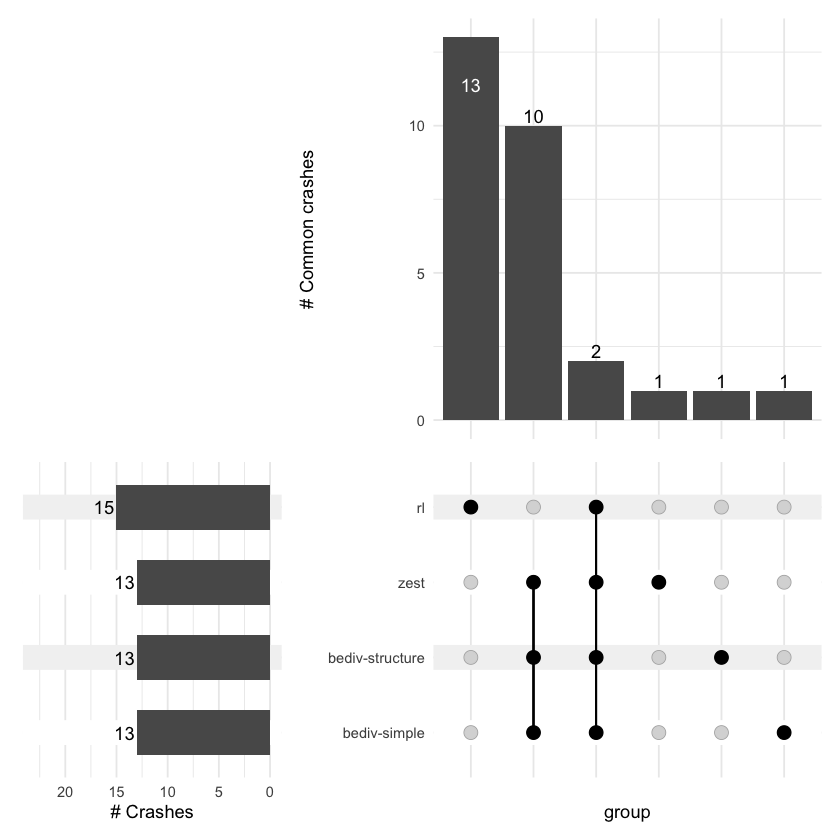

In [111]:
# UpSet plot
cat("UpSet plot of total crash coverage:")

fuzzer_to_unique_crashes <- split(fuzzer_crashes$crash_id, fuzzer_crashes$fuzzer)
fuzzer_to_unique_crashes <- lapply(fuzzer_to_unique_crashes, unique)

crashes_found <- data.frame(sapply(
  fuzzer_to_unique_crashes,
  function(c) unique(fuzzer_crashes$crash_id) %in% c)
)
rownames(crashes_found) <- unique(fuzzer_crashes$crash_id)

upset(
  crashes_found,
  colnames(crashes_found),
  encode_sets = FALSE,  # for annotate() to select the set by name disable encoding
  set_sizes = (
    upset_set_size()
    + geom_text(aes(label = after_stat(count)), hjust = 1.1, stat = "count")
    + expand_limits(y = 23)
    + ylab("# Crashes")
  ),
  base_annotations = list("Intersection size" = intersection_size() + ylab("# Common crashes")),
  labeller = function(labels) {
    chartr(".", "-", labels)
  },
  width_ratio = 0.4,
  height_ratio = 0.75
)

experiment_name <- "eval-bedivfuzz-split-3h"
plot_name <- sprintf(
  "plots/%scrashes/crash_coverage_upset_plot.pdf",
  ifelse(experiment_name == "", "", paste(experiment_name, "/", sep = ""))
)

ggsave(plot_name, create.dir = TRUE)
knitr::plot_crop(plot_name)

In [32]:
# Venn diagram (for 2-4 fuzzers)
#df <- fuzzer_crashes |>
#    select(fuzzer, crash_id)

# Create a list of sets grouped by unique values in B
#3sets_by_B <- split(df$crash_id, df$fuzzer)
#sets_by_B <- lapply(sets_by_B, unique)

# Create the Venn Diagram
#ggvenn(sets_by_B, c("bedivfuzz-havoc", "bedivfuzz-simple", "bedivfuzz-split", "bedivfuzz-structure"))

In [112]:
# Detections per crash_id
cat("Fuzzer detections per crash_id:")
fuzzer_crashes |>
  distinct(fuzzer, crash_id) |>
  group_by(crash_id) |>
  summarize(
    n_fuzzers = n(),
    fuzzers = paste(fuzzer, collapse = ", ")  # Concatenate fuzzers into a single string
  ) |>
  arrange(-n_fuzzers)

Fuzzer detections per crash_id:

crash_id,n_fuzzers,fuzzers
<int>,<int>,<chr>
3,4,"bediv-simple, bediv-structure, rl, zest"
12,4,"bediv-simple, bediv-structure, rl, zest"
0,3,"bediv-simple, bediv-structure, zest"
1,3,"bediv-simple, bediv-structure, zest"
2,3,"bediv-simple, bediv-structure, zest"
4,3,"bediv-simple, bediv-structure, zest"
5,3,"bediv-simple, bediv-structure, zest"
7,3,"bediv-simple, bediv-structure, zest"
8,3,"bediv-simple, bediv-structure, zest"


In [113]:
# Avg. crash coverage per subject
cat("Avg. crash coverage per subject:")
fuzzer_crashes |>
  group_by(fuzzer, subject, trial, crash_id) |>
  filter(tte == min(tte)) |>
  group_by(fuzzer, subject, trial) |>
  summarize(
    crash_coverage = n()
  ) |>
  group_by(fuzzer, subject) |>
  summarize(
    mean_crash_coverage = mean(crash_coverage),
    median_crash_coverage = median(crash_coverage)
  ) |>
  arrange(subject, -mean_crash_coverage)

Avg. crash coverage per subject:

fuzzer,subject,mean_crash_coverage,median_crash_coverage
<chr>,<chr>,<dbl>,<dbl>
zest,closure,5.333333,5
bediv-structure,closure,5.000000,5
bediv-simple,closure,4.933333,5
rl,closure,4.000000,4
bediv-simple,nashorn,1.033333,1
bediv-structure,nashorn,1.000000,1
zest,nashorn,1.000000,1
zest,rhino,4.333333,4
bediv-simple,rhino,3.866667,4


In [114]:
# Mean/median TTE and reliability per crash_id
cat("Avg. TTE and crash reliability per crash_id:")
fuzzer_crashes |>
  filter(crash_id == "C1") |>
  group_by(fuzzer, subject, crash_id, trial) |>
  filter(tte == min(tte)) |> # Only record the first occurence of a crash
  group_by(fuzzer, subject, crash_id) |>
  summarize(
    detections = n(),
    reliability = n() / 30,
    mean_tte = mean(tte),
    median_tte = median(tte)
  ) |>
  group_by(crash_id) |>
  mutate(mean_tte_rank = rank(mean_tte), median_tte_rank = rank(median_tte)) |>
  select(subject, crash_id, fuzzer, detections, reliability, mean_tte, mean_tte_rank, median_tte, median_tte_rank)

Avg. TTE and crash reliability per crash_id:

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `tte == min(tte)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”


subject,crash_id,fuzzer,detections,reliability,mean_tte,mean_tte_rank,median_tte,median_tte_rank
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [115]:
# Mean/median TTE and crash reliability per subject
cat("Avg. TTE and crash reliability per subject:")
fuzzer_crashes |>
  group_by(fuzzer, subject, trial) |>
  filter(tte == min(tte)) |> # Only record the first crash for each trial
  group_by(fuzzer, subject) |>
  summarize(
    crashing_trials = n(),
    crash_reliability = n() / 30,
    mean_tte = mean(tte),
    median_tte = median(tte)
  ) |>
  group_by(subject) |>
  mutate(mean_tte_rank = rank(mean_tte), median_tte_rank = rank(median_tte)) |>
  select(subject, fuzzer, crashing_trials, crash_reliability, mean_tte, mean_tte_rank, median_tte, median_tte_rank) |>
  arrange(subject, fuzzer)

Avg. TTE and crash reliability per subject:

subject,fuzzer,crashing_trials,crash_reliability,mean_tte,mean_tte_rank,median_tte,median_tte_rank
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
closure,bediv-simple,30,1.0000000,6.04296667,4,4.4145,4
closure,bediv-structure,30,1.0000000,4.19653333,3,1.4805,3
closure,rl,30,1.0000000,0.38370000,2,0.3965,2
closure,zest,30,1.0000000,0.29773333,1,0.2625,1
nashorn,bediv-simple,31,1.0333333,2.61496774,1,2.2950,2
nashorn,bediv-structure,30,1.0000000,2.89756667,2,2.0275,1
nashorn,zest,20,0.6666667,29.21980000,3,20.6405,3
rhino,bediv-simple,30,1.0000000,0.05436667,2,0.0365,2
rhino,bediv-structure,30,1.0000000,0.06933333,4,0.0470,3


In [37]:
# Filter out duplicate crashes per trial
unique_crashes <- fuzzer_crashes |>
  group_by(fuzzer, subject, trial, crash_id) |>
  filter(tte == min(tte)) |>
  select(fuzzer, subject, trial, crash_id, tte) |>
  ungroup()

In [38]:
avg_performance <- unique_crashes |>
  group_by(fuzzer, subject, crash_id) |>
  summarize(
    trials_detected = n(),
    mean_tte = mean(tte),
    median_tte = median(tte)
  ) |>
  group_by(subject, crash_id) |>
  mutate(
    mean_tte_rank = rank(mean_tte),
    median_tte_rank = rank(median_tte)
  ) |>
  select(
    subject, crash_id, fuzzer, trials_detected,
    mean_tte, mean_tte_rank, median_tte, median_tte_rank
  )

head(avg_performance)

subject,crash_id,fuzzer,trials_detected,mean_tte,mean_tte_rank,median_tte,median_tte_rank
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
bcel,B1,bedivfuzz-havoc,30,595.2406,4,232.4025,4
bcel,B2,bedivfuzz-havoc,10,3853.0230,2,3266.9135,2
bcel,B3,bedivfuzz-havoc,17,5419.0191,5,5155.5110,5
closure,C1,bedivfuzz-havoc,8,4515.9425,4,5013.0700,5
closure,C2,bedivfuzz-havoc,8,8176.2340,6,8114.2745,6
closure,C3,bedivfuzz-havoc,1,7984.2010,3,7984.2010,3


In [39]:
x <- subset(unique_crashes, crash_id == "R5")

pairwise.wilcox.test(x$tte, x$fuzzer, p.adjust.method = "none", exact = FALSE, paired = FALSE)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  x$tte and x$fuzzer 

                    bedivfuzz-havoc bedivfuzz-simple bedivfuzz-split bedivfuzz-structure
bedivfuzz-simple    0.24            -                -               -                  
bedivfuzz-split     0.18            0.54             -               -                  
bedivfuzz-structure 0.24            1.00             0.54            -                  
zest                0.39            0.29             0.25            0.29               

P value adjustment method: none 

In [40]:
fuzzers <- c(
  "bedivfuzz-havoc", "bedivfuzz-simple", "bedivfuzz-structure", "bedivfuzz-split", "rlcheck", "zest"
)
subjects <- unique(fuzzer_crashes$subject)
trials <- 1:30
crash_ids <- unique(fuzzer_crashes$crash_id)


In [41]:
avg_performance |> filter(crash_id == "B1")

subject,crash_id,fuzzer,trials_detected,mean_tte,mean_tte_rank,median_tte,median_tte_rank
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
bcel,B1,bedivfuzz-havoc,30,595.24063,4,232.4025,4
bcel,B1,bedivfuzz-simple,30,106.90277,2,113.4985,2
bcel,B1,bedivfuzz-split,30,2421.44847,5,1359.3940,5
bcel,B1,bedivfuzz-structure,30,89.49083,1,83.2800,1
bcel,B1,zest,30,550.36957,3,208.6890,3


In [42]:
scores <- unique_crashes |>
  select(fuzzer, subject, trial, crash_id) |>
  # Mark crash as detected for this trial
  mutate(outcome = 1) |>
  # Add remaining rows for trials where a fuzzer did not discover a particular crash
  complete(
    fuzzer = fuzzers,
    subject = subjects,
    trial = trials,
    crash_id = crash_ids
  ) |>
  # Remove additional combinations introduced by complete(), e.g., bcel - C2
  filter(startsWith(tolower(crash_id), substring(subject, 1, 1))) |>
  # Replace NA outcomes with 0
  mutate(outcome = coalesce(outcome, 0)) |>
  filter(crash_id == "B1")

# Get all unique pairwise combinations of fuzzers
fuzzer_combinations <- combn(unique(scores$fuzzer), 2)

# Perform pairwise Fisher's Exact Test
fisher_results <- apply(fuzzer_combinations, 2, function(pair) {
  group1 <- scores$outcome[scores$fuzzer == pair[1]]
  group2 <- scores$outcome[scores$fuzzer == pair[2]]

  # Create a contingency table
  contingency_table <- table(
    Group = c(rep(pair[1], length(group1)), rep(pair[2], length(group2))),
    Outcome = c(group1, group2)
  )

  # If both fuzzers detect the crash in all tables, the 0-outcome column is missing, add it
  if (!("0" %in% dimnames(contingency_table)[[2]])) {
    contingency_table <- cbind(contingency_table, `0` = 0)
  }

  # Fisher's Exact Test
  test_result <- fisher.test(contingency_table)

  data.frame(
    Group1 = pair[1],
    Group2 = pair[2],
    PValue = test_result$p.value
  )
})

# Combine results into a single data frame
fisher_results <- do.call(rbind, fisher_results)
print(fisher_results)

                Group1              Group2       PValue
1      bedivfuzz-havoc    bedivfuzz-simple 1.000000e+00
2      bedivfuzz-havoc     bedivfuzz-split 1.000000e+00
3      bedivfuzz-havoc bedivfuzz-structure 1.000000e+00
4      bedivfuzz-havoc             rlcheck 1.691123e-17
5      bedivfuzz-havoc                zest 1.000000e+00
6     bedivfuzz-simple     bedivfuzz-split 1.000000e+00
7     bedivfuzz-simple bedivfuzz-structure 1.000000e+00
8     bedivfuzz-simple             rlcheck 1.691123e-17
9     bedivfuzz-simple                zest 1.000000e+00
10     bedivfuzz-split bedivfuzz-structure 1.000000e+00
11     bedivfuzz-split             rlcheck 1.691123e-17
12     bedivfuzz-split                zest 1.000000e+00
13 bedivfuzz-structure             rlcheck 1.691123e-17
14 bedivfuzz-structure                zest 1.000000e+00
15             rlcheck                zest 1.691123e-17


In [43]:
head(unique_crashes)

fuzzer,subject,trial,crash_id,tte
<chr>,<chr>,<int>,<chr>,<dbl>
bedivfuzz-havoc,bcel,1,B1,141.681
bedivfuzz-havoc,bcel,1,B2,2016.796
bedivfuzz-havoc,bcel,1,B3,7422.675
bedivfuzz-havoc,bcel,2,B1,126.538
bedivfuzz-havoc,bcel,2,B3,9250.882
bedivfuzz-havoc,bcel,3,B1,73.811


In [44]:
# Statistical bug-eval
evaluate_crash_id <- function(unique_crashes_df, subject, crash_identifier) {
  print_centered(paste("[ Evaluating crash performance for", crash_identifier, "]\n", sep = " "))
  crashes <- filter(unique_crashes_df, crash_id == crash_identifier)

  # Performance overview: avg. TTE, reliability
  print_centered("Performance overview:")
  avg_performance <- crashes |>
    group_by(fuzzer, subject, crash_id) |>
    summarize(
      trials_detected = n(),
      mean_tte = mean(tte),
      median_tte = median(tte)
    ) |>
    group_by(subject, crash_id) |>
    mutate(
      mean_tte_rank = rank(mean_tte),
      median_tte_rank = rank(median_tte)
    ) |>
    select(
      subject, crash_id, fuzzer, trials_detected,
      mean_tte, mean_tte_rank, median_tte, median_tte_rank
    )

  print(avg_performance)

  # Comparison of TTE: Mann-Whitney U test and Vargha-Delaney A12 effect size
  cat("\n\n")
  print_centered("Pairwise statistical comparison of TTE:")
  print(pairwise.wilcox.test(crashes$tte, crashes$fuzzer, p.adjust.method = "none", exact = FALSE, paired = FALSE))

  cat("\n")
  print_centered("Pairwise comparison of effect size (Vargha-Delaney A12):\n")
  # Unique combinations of fuzzer pairs
  fuzzer_combinations <- combn(unique(crashes$fuzzer), 2)

  # Perform pairwise Vargha-Delaney A-Test
  vd_results <- apply(fuzzer_combinations, 2, function(pair) {
    group1 <- crashes$tte[crashes$fuzzer == pair[1]]
    group2 <- crashes$tte[crashes$fuzzer == pair[2]]
    result <- VD.A(group1, group2)
    data.frame(
      Group1 = pair[1],
      Group2 = pair[2],
      A = result$estimate,
      Interpretation = result$magnitude
    )
  })

  # Combine results into a single data frame
  vd_results <- do.call(rbind, vd_results)
  print(vd_results)

  cat("\n\n")
  print_centered("Pairwise comparison of crash reliability (Fisher's exact test):")
  crash_outcomes <- crashes |>
    select(fuzzer, subject, trial, crash_id) |>
    # Mark crash as detected for this trial
    mutate(outcome = 1) |>
    # Add remaining rows for trials where a fuzzer did not discover a particular crash
    complete(
      fuzzer = fuzzers,
      subject = subject,
      trial = trials,
      crash_id = crash_identifier
    ) |>
    # Remove additional combinations introduced by complete(), e.g., bcel - C2
    #filter(startsWith(tolower(crash_id), substring(subject, 1, 1))) |>
    # Replace NA outcomes with 0
    mutate(outcome = coalesce(outcome, 0)) #|>
    #filter(crash_id == "B1")

  # Get all unique pairwise combinations of fuzzers
  fuzzer_combinations <- combn(unique(scores$fuzzer), 2)

  # Perform pairwise Fisher's Exact Test
  fisher_results <- apply(fuzzer_combinations, 2, function(pair) {
    group1 <- scores$outcome[scores$fuzzer == pair[1]]
    group2 <- scores$outcome[scores$fuzzer == pair[2]]

    # Create a contingency table
    contingency_table <- table(
      Group = c(rep(pair[1], length(group1)), rep(pair[2], length(group2))),
      Outcome = c(group1, group2)
    )

    # If both fuzzers detect the crash in all tables, the 0-outcome column is missing, add it
    if (!("0" %in% dimnames(contingency_table)[[2]])) {
      contingency_table <- cbind(contingency_table, `0` = 0)
    }

    # Fisher's Exact Test
    test_result <- fisher.test(contingency_table)

    data.frame(
      Group1 = pair[1],
      Group2 = pair[2],
      PValue = test_result$p.value
    )
  })

  # Combine results into a single data frame
  fisher_results <- do.call(rbind, fisher_results)
  print(fisher_results)
}

In [45]:
evaluate_crash_id(unique_crashes, "closure", "R5")

                               [ Evaluating crash performance for R5 ]
 
                                        Performance overview: 
# A tibble: 5 × 8
# Groups:   subject, crash_id [1]
  subject crash_id fuzzer          trials_detected mean_tte mean_tte_rank median_tte median_tte_rank
  <chr>   <chr>    <chr>                     <int>    <dbl>         <dbl>      <dbl>           <dbl>
1 rhino   R5       bedivfuzz-havoc               5    4929.             3      4627.               3
2 rhino   R5       bedivfuzz-simp…               1    9678.             4      9678.               4
3 rhino   R5       bedivfuzz-split               2    1283.             1      1283.               1
4 rhino   R5       bedivfuzz-stru…               1    9767.             5      9767.               5
5 rhino   R5       zest                          4    2992.             2      3289.               2


                               Pairwise statistical comparison of TTE: 

	Pairwise comparisons using Wi